In [1]:
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

/Users/alexander-fischer/miniconda3/envs/rob_vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# defining parameters for the data loader
base_data_path = os.path.join(os.getcwd(), 'data')
class_labels = ['speedlimit', 'trafficlight', 'crosswalk', 'stop']

batch_size = 64
test_percentage = 0.1
val_percentage = 0.2
classif_threshold = 0.5

In [6]:
def encode_label(label, classes_list=class_labels): # encoding the classes into a tensor of shape (11) with 0 and 1s.
    target = torch.zeros(len(classes_list))
    for lab in label:
      idx = classes_list.index(lab)
      target[idx] = 1.
    return target


def decode_target(pred, threshold=classif_threshold): # decoding the prediction tensors of 0s and 1s into text form
    result = []
    for idx, item in enumerate(pred):
        if (item >= threshold):
          result.append(class_labels[idx])     
    return ' + '.join(result)

In [7]:
## create dataloader for the dataset
class RoadSign_Dataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.class_labels = class_labels
        self.images_folder = os.path.join(data_folder, 'images')
        self.annotations_folder = os.path.join(data_folder, 'annotations')
        self.file_list = os.listdir(self.images_folder)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.images_folder, img_name)
        annotation_path = os.path.join(self.annotations_folder, img_name.replace('.png', '.xml'))

        # Read image
        img = Image.open(img_path).convert("RGB")

        # Apply transform
        if self.transform:
            img = self.transform(img)

        # Parse XML file
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Initialize binary encoding for classes
        class_labels_binary = torch.zeros(len(self.class_labels))

        # Extract class labels
        for object_elem in root.findall('object'):
            label = object_elem.find('name').text
            if label in self.class_labels:
                idx = self.class_labels.index(label)
                class_labels_binary[idx] = 1

        return img, class_labels_binary

## create dataloader for splitting the dataset into equal classes
class RoadSign_Dataset_single(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.class_labels = class_labels
        self.images_folder = os.path.join(data_folder, 'images')
        self.annotations_folder = os.path.join(data_folder, 'annotations')
        self.file_list = os.listdir(self.images_folder)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.images_folder, img_name)
        annotation_path = os.path.join(self.annotations_folder, img_name.replace('.png', '.xml'))

        # Read image
        img = Image.open(img_path).convert("RGB")

        # Apply transform
        if self.transform:
            img = self.transform(img)

        # Parse XML file
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Extract class label
        object_elem = root.find('object')
        class_label = object_elem.find('name').text
        class_label = self.class_labels.index(class_label)

        return img, class_label

# defining the transforms for the dataset
transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384)),
    # normalize the images with imagenet stats
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# creating the dataset
dataset_multiclass = RoadSign_Dataset(data_folder=base_data_path, transform=transform_img)
dataset_singleclass = RoadSign_Dataset_single(data_folder=base_data_path, transform=transform_img)

In [9]:
## create split into train, val and test
dataset_indices = list(range(0, len(dataset_singleclass)))
dataset_labels = [label for _, label in dataset_singleclass]

# split dataset into train and test, but keep the same proportion of each class
train_indices, test_indices = train_test_split(dataset_indices, test_size=test_percentage, random_state=42, stratify=dataset_labels)
train_labels = [dataset_labels[i] for i in train_indices]
train_indices, val_indices = train_test_split(train_indices, test_size=val_percentage, random_state=42, stratify=train_labels)

print(f"Train dataset size: {len(train_indices)}, accounts for {len(train_indices)/len(dataset_indices)*100} % of the dataset")
print(f"Validation dataset size: {len(val_indices)}, accounts for {len(val_indices)/len(dataset_indices)*100} % of the dataset")
print(f"Test dataset size: {len(test_indices)}, accounts for {len(test_indices)/len(dataset_indices)*100} % of the dataset")

## create dataloader for the train, val and test dataset
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = DataLoader(dataset_multiclass, batch_size=batch_size, sampler=train_sampler)
val_dataloader = DataLoader(dataset_multiclass, batch_size=batch_size, sampler=val_sampler)
test_dataloader = DataLoader(dataset_multiclass, batch_size=batch_size, sampler=test_sampler)

Train dataset size: 2160, accounts for 72.0 % of the dataset
Validation dataset size: 540, accounts for 18.0 % of the dataset
Test dataset size: 300, accounts for 10.0 % of the dataset


In [10]:
dataloaders = {
    "train": train_dataloader,
    "val": val_dataloader,
    "test": test_dataloader
}
dataset_sizes = {
    "train": len(train_indices),
    "val": len(val_indices),
    "test": len(test_indices)
}
class_names = dataset_multiclass.class_labels

# make folders for saving the model
tran_learn_path = os.path.join(base_data_path, 'transfer_learning')
os.makedirs(os.path.join(tran_learn_path, 'models'), exist_ok=True)
os.makedirs(os.path.join(tran_learn_path, 'plots'), exist_ok=True)
os.makedirs(os.path.join(tran_learn_path, 'data_tex'), exist_ok=True)

In [7]:
for imgs, labels in dataloaders["train"]:
    print(f"Train images batch shape: {imgs.shape}")
    print(f"Train labels batch shape: {labels.shape}")
    print(labels[:5])
    break

Train images batch shape: torch.Size([64, 3, 384, 384])
Train labels batch shape: torch.Size([64, 4])
tensor([[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 0., 0.]])


In [8]:
# count how many images have 1, 2, 3 classes
split = "test"
class_count = {}
for _, labels in dataloaders[split]:
    for label in labels:
        class_count[label.sum().item()] = class_count.get(label.sum().item(), 0) + 1

# print the class count
print(f"Class count for {split} dataset:")
for k, v in class_count.items():
    print(f"{int(k)} classes: {v} images, accounts for {v/dataset_sizes[split]*100:.1f} % of the dataset")

Class count for test dataset:
1 classes: 237 images, accounts for 79.0 % of the dataset
2 classes: 49 images, accounts for 16.3 % of the dataset
3 classes: 14 images, accounts for 4.7 % of the dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


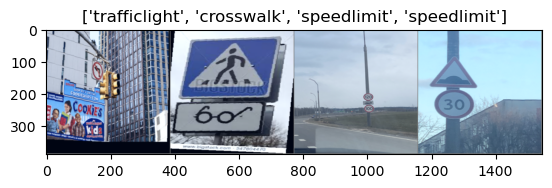

In [9]:
# Visualize a batch of images
def imshow(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], title=None):
    np_img = (img * std[0] + mean[0]).numpy() # unnormalize image and convert to numpy
    plt.imshow(np.transpose(np_img, axes=(1, 2, 0)))
    # plt.axis('off')
    if title is not None:
        plt.title(title)
    # plt.savefig(os.path.join(base_data_path, 'sample_test.png'))
    plt.show()

# get some random training images
images, labels = next(iter(test_dataloader))

# show images
out = make_grid(images[:4])

imshow(out, title=[decode_target(label) for label in labels[:4]])

In [2]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from tempfile import TemporaryDirectory
from tqdm import tqdm

In [17]:
def F_score(output, label, threshold=classif_threshold, beta=1): # Calculate the accuracy of the model; beta=1 for F1 score
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(axis=1).float()
    TN = ((~prob) & (~label)).sum(axis=1).float()
    FP = (prob & (~label)).sum(axis=1).float()
    FN = ((~prob) & label).sum(axis=1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    f_score = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return f_score.mean(dim=0).item()


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_score = 0.0
        best_epoch = 0
        train_dict = {'train_loss': [], 'train_score': [], 'val_loss': [], 'val_score': []}

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 65)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_score = 0.0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], desc=f'{phase} progess'):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs) # shape (batch_size, num_classes)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_score += F_score(F.sigmoid(outputs), labels) * inputs.size(0)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_score = running_score / dataset_sizes[phase]

                if phase == 'train':
                    scheduler.step()
                    train_dict['train_loss'].append(epoch_loss)
                    train_dict['train_score'].append(epoch_score)
                else:
                    train_dict['val_loss'].append(epoch_loss)
                    train_dict['val_score'].append(epoch_score)

                print(f'{phase} loss: {epoch_loss:.4f}, {phase} F1 score: {epoch_score:.4f}')

                # only save the model if it is better than the previous one
                if phase == 'val' and epoch_score > best_score:
                    best_score = epoch_score
                    best_epoch = epoch
                    torch.save(model.state_dict(), best_model_params_path) 
            
            print('-' * 65)
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val F1 score: {best_score:.4f} at epoch {best_epoch+1}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, train_dict

In [12]:
# Visualize a batch of images
def imshow(img, name, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], title=None):
    np_img = (img * std[0] + mean[0]).numpy() # unnormalize image
    plt.imshow(np.transpose(np_img, axes=(1, 2, 0)))
    # plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.savefig(os.path.join(tran_learn_path, 'plots', f'{name}_predictions.png'))
    plt.show()


def visualize_model(model, name, num_images=4, load=False):
    if not load:
        was_training = model.training
        model.eval()
    
    with torch.no_grad():
        inputs, labels = next(iter(test_dataloader))
        inputs = inputs[:num_images].to(device)
        labels = labels[:num_images].to(device)
        
        outputs = model(inputs)
        outputs = F.sigmoid(outputs)

        print(f'Ground Truth:\n{labels.cpu().numpy()}')
        print(f'Prediction:\n{outputs.cpu().numpy()}')

        fig = plt.figure()
        # creating the titles with ground truth and predictions using the decode_target function
        titles = [f'GT: {decode_target(label)} - Pred: {decode_target(pred)}' for label, pred in zip(labels, outputs)]
        img_out = make_grid(inputs.cpu())
        imshow(img_out, name, title=titles)

        if not load:
            model.train(mode=was_training)


def visualize_train(train_dict, name):
    min_val_loss = np.min(train_dict['val_loss'])
    min_val_loss_idx = np.argmin(train_dict['val_loss']) + 1
    max_val_score = np.max(train_dict['val_score'])
    max_val_score_idx = np.argmax(train_dict['val_score']) + 1

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.subplots_adjust(wspace=0.3)
    fig.suptitle(f'Training history of {name}')
    epochs = np.arange(1, len(train_dict['train_loss'])+1, dtype=int)
    ax[0].plot(epochs, train_dict['train_loss'], label='train')
    ax[0].plot(epochs, train_dict['val_loss'], label='val')
    ax[0].plot(min_val_loss_idx, min_val_loss, marker='o', markersize=5, color="green", label="Min. val loss") # mark the minimum validation loss point
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Cross Entropy Loss')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[1].plot(epochs, train_dict['train_score'], label='train')
    ax[1].plot(epochs, train_dict['val_score'], label='val')
    ax[1].plot(max_val_score_idx, max_val_score, marker='o', markersize=5, color="green", label="Max. val F1 score") # mark the maximum validation accuracy point
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('F1 Score')
    ax[1].set_title('Multiclass classification Accuracy')
    ax[1].legend()
    plt.savefig(os.path.join(tran_learn_path, 'plots', f'{name}_train.png'))
    plt.show()

In [8]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.model = models.resnet152(weights='IMAGENET1K_V2')
        # freeze all layers except the last one
        for param in self.model.parameters():
            param.requires_grad = False
        # attach a new last layer for the new classification task
        # num_ftrs = self.model.fc.in_features
        # self.model.fc = nn.Linear(num_ftrs, num_classes) # parameters of newly constructed modules have requires_grad=True by default
        self.model.fc = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        # x = nn.functional.sigmoid(x) --> applied later in the loss criterion to the model's output
        return x

name = 'model_conv_resnet152_imagenetv2_multiclass_finetune'
model_conv = TransferLearningModel(num_classes=len(class_labels))
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model_conv = model_conv.to(device)
# print(model_conv) # print the model architecture

# for name, param in model_conv.model.named_parameters():
#     if param.requires_grad == True:
#         print(name)

criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy Loss with sigmoid applied to the output
optimizer_conv = optim.Adam(model_conv.model.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 after every 30 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=30, gamma=0.1)

In [14]:
model_conv, train_dict = train_model(model_conv.model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=30)

Epoch 1/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:24<00:00,  2.48s/it]


train loss: 0.4564, train F1 score: 0.5127


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.17s/it]


val loss: 0.3017, val F1 score: 0.8616
-----------------------------------------------------------------

Epoch 2/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.2356, train F1 score: 0.8879


val progess: 100%|██████████| 9/9 [00:20<00:00,  2.23s/it]


val loss: 0.1845, val F1 score: 0.9330
-----------------------------------------------------------------

Epoch 3/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.52s/it]


train loss: 0.1546, train F1 score: 0.9379


val progess: 100%|██████████| 9/9 [00:20<00:00,  2.23s/it]


val loss: 0.1287, val F1 score: 0.9546
-----------------------------------------------------------------

Epoch 4/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.1116, train F1 score: 0.9617


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.1137, val F1 score: 0.9522
-----------------------------------------------------------------

Epoch 5/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.52s/it]


train loss: 0.0877, train F1 score: 0.9723


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0822, val F1 score: 0.9723
-----------------------------------------------------------------

Epoch 6/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0673, train F1 score: 0.9826


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.19s/it]


val loss: 0.0686, val F1 score: 0.9791
-----------------------------------------------------------------

Epoch 7/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0583, train F1 score: 0.9829


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0629, val F1 score: 0.9799
-----------------------------------------------------------------

Epoch 8/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0464, train F1 score: 0.9872


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.19s/it]


val loss: 0.0558, val F1 score: 0.9811
-----------------------------------------------------------------

Epoch 9/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0416, train F1 score: 0.9886


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.19s/it]


val loss: 0.0477, val F1 score: 0.9845
-----------------------------------------------------------------

Epoch 10/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0323, train F1 score: 0.9941


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0440, val F1 score: 0.9858
-----------------------------------------------------------------

Epoch 11/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.50s/it]


train loss: 0.0274, train F1 score: 0.9934


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0399, val F1 score: 0.9875
-----------------------------------------------------------------

Epoch 12/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0250, train F1 score: 0.9933


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.19s/it]


val loss: 0.0406, val F1 score: 0.9826
-----------------------------------------------------------------

Epoch 13/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.50s/it]


train loss: 0.0233, train F1 score: 0.9952


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.19s/it]


val loss: 0.0356, val F1 score: 0.9881
-----------------------------------------------------------------

Epoch 14/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:29<00:00,  2.62s/it]


train loss: 0.0195, train F1 score: 0.9964


val progess: 100%|██████████| 9/9 [03:43<00:00, 24.81s/it] 


val loss: 0.0345, val F1 score: 0.9885
-----------------------------------------------------------------

Epoch 15/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0179, train F1 score: 0.9967


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0311, val F1 score: 0.9873
-----------------------------------------------------------------

Epoch 16/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.50s/it]


train loss: 0.0142, train F1 score: 0.9978


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0296, val F1 score: 0.9888
-----------------------------------------------------------------

Epoch 17/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0141, train F1 score: 0.9979


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0283, val F1 score: 0.9896
-----------------------------------------------------------------

Epoch 18/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.50s/it]


train loss: 0.0118, train F1 score: 0.9990


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.19s/it]


val loss: 0.0285, val F1 score: 0.9895
-----------------------------------------------------------------

Epoch 19/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:24<00:00,  2.50s/it]


train loss: 0.0127, train F1 score: 0.9979


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0271, val F1 score: 0.9901
-----------------------------------------------------------------

Epoch 20/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0111, train F1 score: 0.9986


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0277, val F1 score: 0.9882
-----------------------------------------------------------------

Epoch 21/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.50s/it]


train loss: 0.0090, train F1 score: 0.9995


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0245, val F1 score: 0.9909
-----------------------------------------------------------------

Epoch 22/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0083, train F1 score: 0.9988


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.19s/it]


val loss: 0.0244, val F1 score: 0.9892
-----------------------------------------------------------------

Epoch 23/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:29<00:00,  2.63s/it]


train loss: 0.0074, train F1 score: 0.9995


val progess: 100%|██████████| 9/9 [07:27<00:00, 49.74s/it] 


val loss: 0.0264, val F1 score: 0.9898
-----------------------------------------------------------------

Epoch 24/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.52s/it]


train loss: 0.0071, train F1 score: 0.9997


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0246, val F1 score: 0.9886
-----------------------------------------------------------------

Epoch 25/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0061, train F1 score: 0.9991


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0243, val F1 score: 0.9902
-----------------------------------------------------------------

Epoch 26/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0066, train F1 score: 0.9995


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.21s/it]


val loss: 0.0237, val F1 score: 0.9899
-----------------------------------------------------------------

Epoch 27/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0076, train F1 score: 0.9990


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0235, val F1 score: 0.9921
-----------------------------------------------------------------

Epoch 28/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:25<00:00,  2.51s/it]


train loss: 0.0069, train F1 score: 0.9988


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0229, val F1 score: 0.9918
-----------------------------------------------------------------

Epoch 29/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:24<00:00,  2.50s/it]


train loss: 0.0053, train F1 score: 0.9997


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.20s/it]


val loss: 0.0254, val F1 score: 0.9893
-----------------------------------------------------------------

Epoch 30/30
-----------------------------------------------------------------


train progess: 100%|██████████| 34/34 [01:24<00:00,  2.50s/it]


train loss: 0.0045, train F1 score: 0.9999


val progess: 100%|██████████| 9/9 [00:19<00:00,  2.22s/it]


val loss: 0.0232, val F1 score: 0.9904
-----------------------------------------------------------------

Training complete in 63m 20s
Best val F1 score: 0.9921 at epoch 27


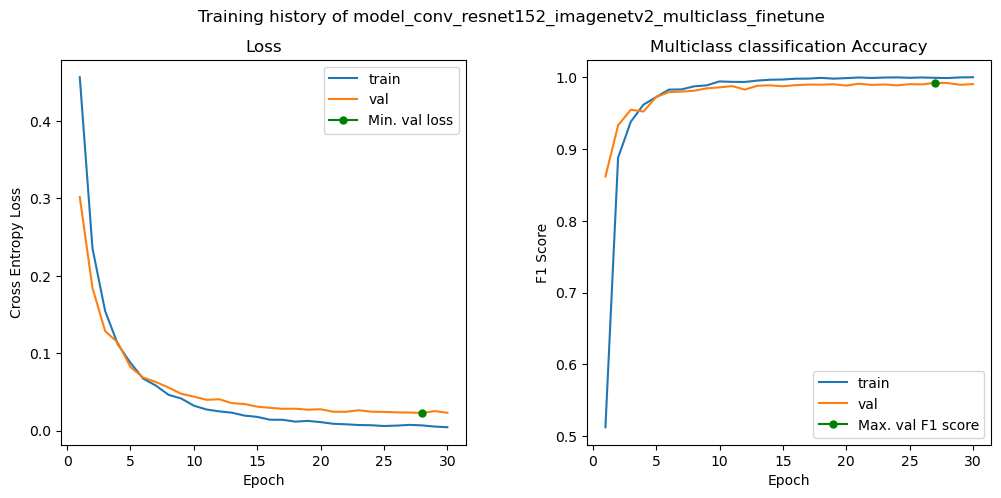

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth:
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 0.]]
Prediction:
[[3.06586910e-04 9.99767721e-01 1.18187512e-03 7.31574837e-04]
 [9.99999404e-01 1.97834993e-06 2.57667834e-05 1.63128743e-06]
 [1.82513264e-04 9.99396443e-01 9.84789789e-01 2.63351307e-04]
 [9.99996185e-01 4.52923587e-07 6.97360611e-06 1.17981726e-04]]


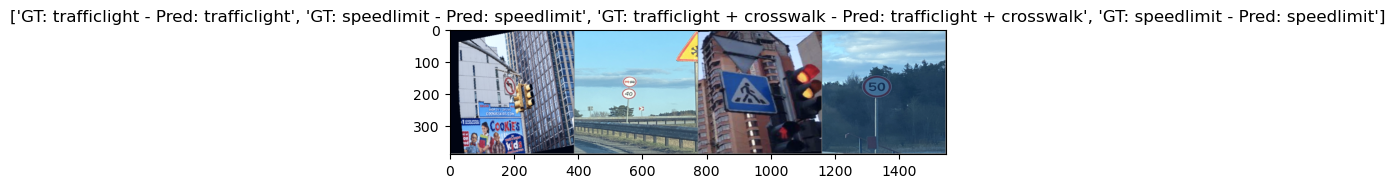

In [15]:
# save model
torch.save(model_conv.state_dict(), os.path.join(tran_learn_path, 'models', f'{name}.pt'))

# write out train_dict for later plotting in latex tikz
train_dict_df = pd.DataFrame(train_dict)
train_dict_df.to_csv(os.path.join(tran_learn_path, 'data_tex', f'{name}.csv'), index=False)

visualize_train(train_dict, name)
visualize_model(model_conv, name)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ground Truth:
[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
Prediction:
[[5.1760149e-01 4.9207305e-05 1.3538671e-04 9.8115551e-01]
 [1.3292318e-02 1.2011349e-03 2.4126146e-03 9.9681658e-01]
 [3.7147656e-01 3.9065373e-03 9.8512888e-01 6.9616115e-05]
 [1.4628718e-03 9.9217707e-01 8.6390294e-02 2.7425587e-03]]


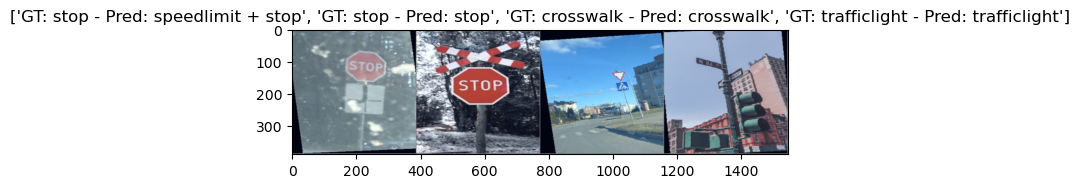

In [13]:
## load the saved model and run visualization
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

model_conv = TransferLearningModel(num_classes=len(class_labels))
model_conv = model_conv.to(device)
model_conv.model.load_state_dict(torch.load(os.path.join(tran_learn_path, 'models', f'{name}.pt')))

visualize_model(model_conv, name, load=True)

In [14]:
def classif_overall(model, dataloader=dataloaders['test'], relative=True):
    running_loss = 0.0
    running_score = 0.0
    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predictions = F.sigmoid(outputs)

            running_loss += loss.item() * inputs.size(0)
            running_score += F_score(predictions, labels) * inputs.size(0)

            for label, prediction in zip(labels, predictions): # iterate over the batch
                total += label.size(0)
                correct += (torch.round(prediction) == label).sum().item()
        
        test_loss = running_loss / dataset_sizes['test']
        test_score = 100 * running_score / dataset_sizes['test']
        test_acc = 100 * correct / total
        if relative: # compute relative loss in overall classification accuracy
            test_acc_rel = test_acc / reference_abs[0]
        else:
            test_acc_rel = 1.

    print(f'Validation Loss on {dataset_sizes["test"]} test images: {test_loss:.3f}')
    print(f'Validation total accuracy on {dataset_sizes["test"]} test images: {test_acc:.1f} %')
    print(f'Validation F1 score on {dataset_sizes["test"]} test images: {test_score:.1f} %\n')

    return np.array([test_acc]), np.array([test_acc_rel]), np.array([test_score])

In [15]:
def classif_report(model, dataloader=dataloaders['test'], relative=True):
    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in class_names}
    total_pred = {classname: 0 for classname in class_names}
    pred_label_lengths = {i: 0 for i in range(1,4)} # number of images with i labels
    gt_label_lengths = {i: 0 for i in range(1,4)} # number of images with i labels

    # Initialize variables for total accuracy computation
    total_correct_images = 0
    total_images = 0

    acc_classes = []
    rel_acc_losses = []
    acc_num_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            predictions = torch.round(F.sigmoid(outputs)) # round predictions to the nearest integer (0 or 1)

            # Convert labels and predictions to numpy arrays for looping through
            labels = labels.cpu().numpy().astype(int)
            predictions = predictions.cpu().numpy()

            # Collect the correct predictions for each class of every single image/label pair
            for label, prediction in zip(labels, predictions):
                for classname in class_names:
                    label_class = class_names.index(classname)
                    if label[label_class] == prediction[label_class]:
                        correct_pred[classname] += 1
                    total_pred[classname] += 1

                # Check if all predicted labels match the ground truth labels
                num_labels = np.sum(label) # number of unique labels in the ground truth label vector
                if (label == prediction).all():
                    total_correct_images += 1
                    pred_label_lengths[num_labels] += 1
                total_images += 1
                gt_label_lengths[num_labels] += 1

    # Print accuracy for each class
    if relative:
        for (classname, correct_count), ref in zip(correct_pred.items(), reference_abs[2:6]):
            accuracy = 100 * float(correct_count) / total_pred[classname]
            acc_classes.append(accuracy)
            rel_acc_losses.append(accuracy / ref)
            print(f'Accuracy for class _{classname}_ is {accuracy:.1f} %')
        print()
    else:
        for (classname, correct_count) in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            acc_classes.append(accuracy)
            rel_acc_losses.append(1.)
            print(f'Accuracy for class _{classname}_ is {accuracy:.1f} %')
        print()

    # Compute total accuracy
    total_label_acc = 100 * float(total_correct_images) / total_images
    if relative:
        rel_total_label_acc = total_label_acc / reference_abs[6]
    else:
        rel_total_label_acc = 1.
    print(f'Accuracy of entirely matched labels: {total_label_acc:.1f} %')

    # Compute accuracy for each number of labels
    for i in range(1, 4):
        acc_per_num_label = 100 * float(pred_label_lengths[i]) / gt_label_lengths[i] # accuracy of images with i labels that are *entirely* matched
        acc_num_labels.append(acc_per_num_label)
        if i == 1:
            print(f'Accuracy of entirely matched test images with {i} label: {acc_per_num_label:.1f} %')
        else:
            print(f'Accuracy of entirely matched test images with {i} labels: {acc_per_num_label:.1f} %')
    print()

    return np.array(acc_classes), np.array(rel_acc_losses), np.array([total_label_acc]), np.array([rel_total_label_acc]), np.array(acc_num_labels)

In [18]:
acc_overall, rel_acc_all, f1_score = classif_overall(model_conv, dataloader=dataloaders['test'], relative=False)
acc_per_class, rel_acc_class, total_label_acc, rel_total_label_acc, acc_num_labels = classif_report(model_conv, dataloader=dataloaders['test'], relative=False)

reference_abs = np.concatenate((acc_overall, f1_score, acc_per_class, total_label_acc, acc_num_labels))
reference_rel = np.concatenate((rel_acc_all, rel_acc_class, rel_total_label_acc))

acc_names = [f'acc_{label}' for label in class_labels]
rel_acc_names = [f'acc_rel_{label}' for label in class_labels]
acc_num_label_names = [f'acc_num_label_{i}' for i in range(1, 4)]
df_eval_abs = pd.DataFrame(columns=['Overall_acc', 'F1_score', *acc_names, 'Total_label_acc', *acc_num_label_names])
df_eval_rel = pd.DataFrame(columns=['Rel_acc_all', *rel_acc_names, 'Rel_total_label_acc'])

# append the reference array to the dataframe as a new row
df_eval_abs.loc[0] = reference_abs
df_eval_rel.loc[0] = reference_rel

df_eval_abs
# df_eval_rel

Testing: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Validation Loss on 300 test images: 0.033
Validation total accuracy on 300 test images: 98.9 %
Validation F1 score on 300 test images: 98.7 %



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]

Accuracy for class _speedlimit_ is 99.3 %
Accuracy for class _trafficlight_ is 99.0 %
Accuracy for class _crosswalk_ is 98.0 %
Accuracy for class _stop_ is 99.3 %

Accuracy of entirely matched labels: 96.0 %
Accuracy of entirely matched test images with 1 label: 97.9 %
Accuracy of entirely matched test images with 2 labels: 85.7 %
Accuracy of entirely matched test images with 3 labels: 100.0 %



,Overall_acc,F1_score,acc_speedlimit,acc_trafficlight,acc_crosswalk,acc_stop,Total_label_acc,acc_num_label_1,acc_num_label_2,acc_num_label_3
0,98.916667,98.693969,99.333333,99.0,98.0,99.333333,96.0,97.890295,85.714286,100.0


### Evalution of the corrupted image datasets

In [19]:
test_data_path = os.path.join(base_data_path, 'test_images')

In [20]:
## create dataloader for the dataset
class RoadSign_Dataset(Dataset):
    def __init__(self, data_folder, corruption, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.class_labels = class_labels
        self.images_folder = os.path.join(data_folder, 'corruptions', corruption)
        self.annotations_folder = os.path.join(data_folder, 'annotations')
        self.file_list = os.listdir(self.images_folder)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.images_folder, img_name)
        annotation_path = os.path.join(self.annotations_folder, img_name.replace('.png', '.xml'))

        # Read image
        img = Image.open(img_path).convert("RGB")

        # Apply transform
        if self.transform:
            img = self.transform(img)

        # Parse XML file
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Initialize binary encoding for classes
        class_labels_binary = torch.zeros(len(self.class_labels))

        # Extract class labels
        for object_elem in root.findall('object'):
            label = object_elem.find('name').text
            if label in self.class_labels:
                idx = self.class_labels.index(label)
                class_labels_binary[idx] = 1

        return img, class_labels_binary

# defining the transforms for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # normalize the images with imagenet stats
    transforms.Resize((384, 384)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

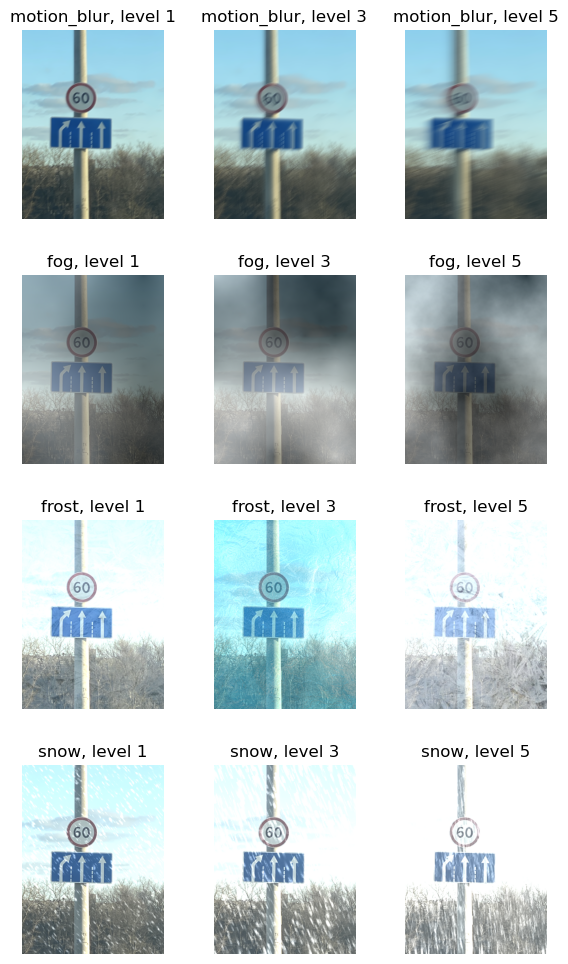

In [21]:
corruption_types = ['motion_blur', 'fog', 'frost', 'snow']
corruption_levels = [1, 3, 5]

# plot the same single image with different corruption levels for each corruption type (row) and each severity level (column)
fig, ax = plt.subplots(len(corruption_types), len(corruption_levels), figsize=(7, 12))
fig.subplots_adjust(hspace=0.3)

for i, corruption_type in enumerate(corruption_types):
    for j, corruption_level in enumerate(corruption_levels):
        path = os.path.join(test_data_path, 'corruptions', corruption_type, f'severity_{corruption_level}')
        img = Image.open(os.path.join(path, os.listdir(path)[10])).convert("RGB")
        ax[i, j].imshow(img)
        ax[i, j].set_title(f'{corruption_type}, level {corruption_level}')
        ax[i, j].axis('off')
plt.savefig(os.path.join(base_data_path, 'corruption_examples.png'))
plt.show()

In [22]:
corruption_types = ['motion_blur', 'fog', 'frost', 'snow']
corruption_levels = [1, 3, 5]

index_names = ['Test_dataset']
idx = 1
for corruption in corruption_types:
    for level in corruption_levels:
        print('-' * 65)
        print(f'Corruption_type: {corruption}, severity_level: {level}\n')
        
        index_names.append(f'{corruption}_level_{level}')
        corruption_rel_path = os.path.join(corruption, f'severity_{level}')
        # creating the dataset
        dataset = RoadSign_Dataset(data_folder=test_data_path, corruption=corruption_rel_path, transform=transform)
        # create dataloader for the dataset
        test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        acc_overall, rel_acc_all, f1_score = classif_overall(model_conv, dataloader=test_dataloader, relative=True)
        acc_per_class, rel_acc_class, total_label_acc, rel_total_label_acc, acc_num_labels = classif_report(model_conv, dataloader=test_dataloader, relative=True)

        values_abs = np.concatenate((acc_overall, f1_score, acc_per_class, total_label_acc, acc_num_labels))
        values_rel = np.concatenate((rel_acc_all, rel_acc_class, rel_total_label_acc))
        df_eval_abs.loc[idx] = values_abs
        df_eval_rel.loc[idx] = values_rel
    
        idx += 1
    # add average values for each corruption type
    index_names.append(f'{corruption}_average')
    df_eval_abs.loc[idx] = df_eval_abs.loc[idx-3:idx].mean(axis=0)
    df_eval_rel.loc[idx] = df_eval_rel.loc[idx-3:idx].mean(axis=0)
    idx += 1

-----------------------------------------------------------------
Corruption_type: motion_blur, severity_level: 1



Testing: 100%|██████████| 5/5 [00:12<00:00,  2.52s/it]


Validation Loss on 300 test images: 0.122
Validation total accuracy on 300 test images: 96.1 %
Validation F1 score on 300 test images: 93.2 %



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Accuracy for class _speedlimit_ is 99.0 %
Accuracy for class _trafficlight_ is 96.0 %
Accuracy for class _crosswalk_ is 93.3 %
Accuracy for class _stop_ is 96.0 %

Accuracy of entirely matched labels: 86.3 %
Accuracy of entirely matched test images with 1 label: 91.1 %
Accuracy of entirely matched test images with 2 labels: 69.4 %
Accuracy of entirely matched test images with 3 labels: 64.3 %

-----------------------------------------------------------------
Corruption_type: motion_blur, severity_level: 3



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Validation Loss on 300 test images: 0.588
Validation total accuracy on 300 test images: 85.8 %
Validation F1 score on 300 test images: 73.2 %



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.32s/it]


Accuracy for class _speedlimit_ is 92.7 %
Accuracy for class _trafficlight_ is 85.3 %
Accuracy for class _crosswalk_ is 80.7 %
Accuracy for class _stop_ is 84.3 %

Accuracy of entirely matched labels: 60.7 %
Accuracy of entirely matched test images with 1 label: 70.0 %
Accuracy of entirely matched test images with 2 labels: 32.7 %
Accuracy of entirely matched test images with 3 labels: 0.0 %

-----------------------------------------------------------------
Corruption_type: motion_blur, severity_level: 5



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Validation Loss on 300 test images: 1.074
Validation total accuracy on 300 test images: 80.9 %
Validation F1 score on 300 test images: 64.6 %



Testing: 100%|██████████| 5/5 [00:12<00:00,  2.44s/it]


Accuracy for class _speedlimit_ is 89.7 %
Accuracy for class _trafficlight_ is 83.0 %
Accuracy for class _crosswalk_ is 72.7 %
Accuracy for class _stop_ is 78.3 %

Accuracy of entirely matched labels: 50.7 %
Accuracy of entirely matched test images with 1 label: 62.4 %
Accuracy of entirely matched test images with 2 labels: 8.2 %
Accuracy of entirely matched test images with 3 labels: 0.0 %

-----------------------------------------------------------------
Corruption_type: fog, severity_level: 1



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Validation Loss on 300 test images: 0.102
Validation total accuracy on 300 test images: 96.7 %
Validation F1 score on 300 test images: 94.2 %



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Accuracy for class _speedlimit_ is 98.0 %
Accuracy for class _trafficlight_ is 98.3 %
Accuracy for class _crosswalk_ is 92.7 %
Accuracy for class _stop_ is 97.7 %

Accuracy of entirely matched labels: 88.3 %
Accuracy of entirely matched test images with 1 label: 92.8 %
Accuracy of entirely matched test images with 2 labels: 75.5 %
Accuracy of entirely matched test images with 3 labels: 57.1 %

-----------------------------------------------------------------
Corruption_type: fog, severity_level: 3



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Validation Loss on 300 test images: 0.146
Validation total accuracy on 300 test images: 95.3 %
Validation F1 score on 300 test images: 92.3 %



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Accuracy for class _speedlimit_ is 98.0 %
Accuracy for class _trafficlight_ is 96.3 %
Accuracy for class _crosswalk_ is 89.7 %
Accuracy for class _stop_ is 97.3 %

Accuracy of entirely matched labels: 84.0 %
Accuracy of entirely matched test images with 1 label: 92.4 %
Accuracy of entirely matched test images with 2 labels: 55.1 %
Accuracy of entirely matched test images with 3 labels: 42.9 %

-----------------------------------------------------------------
Corruption_type: fog, severity_level: 5



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Validation Loss on 300 test images: 0.434
Validation total accuracy on 300 test images: 88.2 %
Validation F1 score on 300 test images: 74.7 %



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.26s/it]


Accuracy for class _speedlimit_ is 94.7 %
Accuracy for class _trafficlight_ is 86.0 %
Accuracy for class _crosswalk_ is 76.0 %
Accuracy for class _stop_ is 96.0 %

Accuracy of entirely matched labels: 63.3 %
Accuracy of entirely matched test images with 1 label: 75.9 %
Accuracy of entirely matched test images with 2 labels: 14.3 %
Accuracy of entirely matched test images with 3 labels: 21.4 %

-----------------------------------------------------------------
Corruption_type: frost, severity_level: 1



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Validation Loss on 300 test images: 0.261
Validation total accuracy on 300 test images: 91.4 %
Validation F1 score on 300 test images: 83.2 %



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]


Accuracy for class _speedlimit_ is 96.7 %
Accuracy for class _trafficlight_ is 82.0 %
Accuracy for class _crosswalk_ is 92.7 %
Accuracy for class _stop_ is 94.3 %

Accuracy of entirely matched labels: 72.7 %
Accuracy of entirely matched test images with 1 label: 79.7 %
Accuracy of entirely matched test images with 2 labels: 55.1 %
Accuracy of entirely matched test images with 3 labels: 14.3 %

-----------------------------------------------------------------
Corruption_type: frost, severity_level: 3



Testing: 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]


Validation Loss on 300 test images: 0.733
Validation total accuracy on 300 test images: 79.7 %
Validation F1 score on 300 test images: 62.6 %



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


Accuracy for class _speedlimit_ is 91.0 %
Accuracy for class _trafficlight_ is 71.7 %
Accuracy for class _crosswalk_ is 81.3 %
Accuracy for class _stop_ is 74.7 %

Accuracy of entirely matched labels: 48.0 %
Accuracy of entirely matched test images with 1 label: 57.4 %
Accuracy of entirely matched test images with 2 labels: 16.3 %
Accuracy of entirely matched test images with 3 labels: 0.0 %

-----------------------------------------------------------------
Corruption_type: frost, severity_level: 5



Testing: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Validation Loss on 300 test images: 0.866
Validation total accuracy on 300 test images: 77.1 %
Validation F1 score on 300 test images: 57.9 %



Testing: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Accuracy for class _speedlimit_ is 89.3 %
Accuracy for class _trafficlight_ is 67.7 %
Accuracy for class _crosswalk_ is 78.0 %
Accuracy for class _stop_ is 73.3 %

Accuracy of entirely matched labels: 44.3 %
Accuracy of entirely matched test images with 1 label: 52.3 %
Accuracy of entirely matched test images with 2 labels: 18.4 %
Accuracy of entirely matched test images with 3 labels: 0.0 %

-----------------------------------------------------------------
Corruption_type: snow, severity_level: 1



Testing: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Validation Loss on 300 test images: 0.350
Validation total accuracy on 300 test images: 88.2 %
Validation F1 score on 300 test images: 70.8 %



Testing: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


Accuracy for class _speedlimit_ is 86.7 %
Accuracy for class _trafficlight_ is 89.7 %
Accuracy for class _crosswalk_ is 88.3 %
Accuracy for class _stop_ is 88.0 %

Accuracy of entirely matched labels: 62.3 %
Accuracy of entirely matched test images with 1 label: 70.0 %
Accuracy of entirely matched test images with 2 labels: 30.6 %
Accuracy of entirely matched test images with 3 labels: 42.9 %

-----------------------------------------------------------------
Corruption_type: snow, severity_level: 3



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Validation Loss on 300 test images: 0.633
Validation total accuracy on 300 test images: 82.3 %
Validation F1 score on 300 test images: 59.2 %



Testing: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Accuracy for class _speedlimit_ is 88.3 %
Accuracy for class _trafficlight_ is 85.0 %
Accuracy for class _crosswalk_ is 75.0 %
Accuracy for class _stop_ is 81.0 %

Accuracy of entirely matched labels: 45.7 %
Accuracy of entirely matched test images with 1 label: 55.3 %
Accuracy of entirely matched test images with 2 labels: 12.2 %
Accuracy of entirely matched test images with 3 labels: 0.0 %

-----------------------------------------------------------------
Corruption_type: snow, severity_level: 5



Testing: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Validation Loss on 300 test images: 0.770
Validation total accuracy on 300 test images: 80.7 %
Validation F1 score on 300 test images: 54.6 %



Testing: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

Accuracy for class _speedlimit_ is 88.0 %
Accuracy for class _trafficlight_ is 81.3 %
Accuracy for class _crosswalk_ is 71.3 %
Accuracy for class _stop_ is 82.0 %

Accuracy of entirely matched labels: 44.3 %
Accuracy of entirely matched test images with 1 label: 54.4 %
Accuracy of entirely matched test images with 2 labels: 8.2 %
Accuracy of entirely matched test images with 3 labels: 0.0 %



In [23]:
df_eval_abs.set_index(pd.Index(index_names), inplace=True)
df_eval_rel.set_index(pd.Index(index_names), inplace=True)
df_eval_abs.to_csv(os.path.join(tran_learn_path, 'data_tex', 'cnn_final_eval_abs_finetune.csv'), index=True)
df_eval_rel.to_csv(os.path.join(tran_learn_path, 'data_tex', 'cnn_final_eval_rel_finetune.csv'), index=True)

df_eval_abs
# df_eval_rel

,Overall_acc,F1_score,acc_speedlimit,acc_trafficlight,acc_crosswalk,acc_stop,Total_label_acc,acc_num_label_1,acc_num_label_2,acc_num_label_3
Test_dataset,98.916667,98.693969,99.333333,99.000000,98.000000,99.333333,96.000000,97.890295,85.714286,100.000000
motion_blur_level_1,96.083333,93.240834,99.000000,96.000000,93.333333,96.000000,86.333333,91.139241,69.387755,64.285714
motion_blur_level_3,85.750000,73.158182,92.666667,85.333333,80.666667,84.333333,60.666667,70.042194,32.653061,0.000000
motion_blur_level_5,80.916667,64.643653,89.666667,83.000000,72.666667,78.333333,50.666667,62.447257,8.163265,0.000000
motion_blur_average,87.583333,77.014223,93.777778,88.111111,82.222222,86.222222,65.888889,74.542897,36.734694,21.428571
fog_level_1,96.666667,94.238435,98.000000,98.333333,92.666667,97.666667,88.333333,92.827004,75.510204,57.142857
fog_level_3,95.333333,92.309031,98.000000,96.333333,89.666667,97.333333,84.000000,92.405063,55.102041,42.857143
fog_level_5,88.166667,74.674844,94.666667,86.000000,76.000000,96.000000,63.333333,75.949367,14.285714,21.428571
fog_average,93.388889,87.074104,96.888889,93.555556,86.111111,97.000000,78.555556,87.060478,48.299320,40.476190
frost_level_1,91.416667,83.222040,96.666667,82.000000,92.666667,94.333333,72.666667,79.746835,55.102041,14.285714


In [ ]:
# Corruption Level 1:
# - acc_one_sign: (91.1 + 92.8 + 79.7 + 70) / 4 = 83.4
# - acc_two_signs: (69.4 + 75.5 + 55.1 + 30.6) / 4 = 57.7
# - acc_three_signs: (64.3 + 57.1 + 14.3 + 42.9) / 4 = 44.6

# Corruption Level 3:
# - acc_one_sign: (70 + 92.4 + 57.4 + 55.3) / 4 = 68.8
# - acc_two_signs: (32.7 + 55.1 + 16.3 + 12.2) / 4 = 29.1
# - acc_three_signs: (0 + 42.9 + 0 + 0) / 4 = 10.7

# Corruption Level 5:
# - acc_one_sign: (62.4 + 75.9 + 52.3 + 54.4) / 4 = 61.2
# - acc_two_signs: (8.2 + 14.3 + 18.4 + 8.2) / 4 = 12.3
# - acc_three_signs: (0 + 21.4 + 0 + 0) / 4 = 5.4

### Observations

- In general: accuracy of the model _decreases with increasing corruption severity_ (as expected)
- Frost and snow are the most difficult to classify, with lowest accuracy / F1 score
- Trafficlight & stop sign are the _easiest_ to classify $\rightarrow$ most distinct features like color and shape (poll); crosswalk sign sometimes confused with other blue signs
- Stop sign loses the _least_ accuracy with increasing corruption severity
- Accuracy of _entirely_ matched labels _dramtically decreases_ with
    - increasing number of unique labels in the image (across image corruption types) $\rightarrow$ if the model is still able to predict anything at all, it can only focus on the most dominant label
    - increasing number of corruption severity levels